In [953]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys
import pylab as pl
import re
import urllib.request as request
from datetime import datetime
from bs4 import BeautifulSoup

matplotlib.rcParams['figure.titlesize'] = 'large'
matplotlib.rcParams['figure.figsize'] = (20, 20)
             
% pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Collect data January turnstile data (2017 & 2016)

In [19]:
MTA_TURNSTILE_URL = "http://web.mta.info/developers/turnstile.html"
MTA_FILE_ROOT_URL = "http://web.mta.info/developers/"

In [35]:
'''
slightly modified from https://github.com/piratefsh/mta-turnstile-scraper/blob/master/mta_scraper.py'''

def get_site():
    f = request.urlopen(MTA_TURNSTILE_URL)
    content = f.read()
    return content

def get_turnstile_links(html):
    soup = BeautifulSoup(html, 'html.parser')
    links = soup.find_all('a')
    turnstile_links = [(link.text, MTA_FILE_ROOT_URL + link['href']) for link in links if re.match('.*day.*20..', link.text)]
    return turnstile_links 

def get_links_by_date(start, end):
    links = get_links()
    in_range = []
    for text,link in links:
        date = datetime.datetime.strptime(text , "%A, %B %d, %Y") 
        if date >= start and date <= end:
            in_range.append((text, link))
    
    return in_range

def get_links():
    return get_turnstile_links(get_site())

In [338]:
metadata = 'http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description_pre-10-18-2014.txt'
f = request.urlopen(metadata)
content = f.readlines()
col_names_14 = str(content[2]).split(',')

def turnstile_df(links, post2014 = True): 
    '''takes links and returns dataframe with all data in one
    pre 2014 was captured differently and thus requires a second argument for correct columns'''
    df = pd.DataFrame()
    if post2014 == True: 
        for text, link in links: 
            temp_df = pd.read_csv(link, parse_dates = True, infer_datetime_format = True)
            df = df.append(temp_df, ignore_index = True)
    elif post2014 == False: 
        for text, link in links: 
            temp_df = pd.read_csv(link, header = None, names = col_names_14, parse_dates = True,
                                 infer_datetime_format = True)
            df = df.append(temp_df, ignore_index = True)
    return df

In [647]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2015, 12, 30)
end = datetime.datetime(2016, 2, 5)
desired = get_links_by_date(start, end)
jan2016 = turnstile_df(desired)

In [628]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2016, 12, 30)
end = datetime.datetime(2017, 2, 3)
desired = get_links_by_date(start, end)
jan2017 = turnstile_df(desired)

In [629]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2014, 12, 30)
end = datetime.datetime(2015, 2, 3)
desired = get_links_by_date(start, end)
jan2015 = turnstile_df(desired)

In [630]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2013, 12, 30)
end = datetime.datetime(2014, 2, 5)
desired = get_links_by_date(start, end)
jan2014 = turnstile_df(desired, False)

In [631]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2012, 12, 30)
end = datetime.datetime(2013, 2, 5)
desired = get_links_by_date(start, end)
jan2013 = turnstile_df(desired, False)

In [632]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2011, 12, 30)
end = datetime.datetime(2012, 2, 5)
desired = get_links_by_date(start, end)
jan2012 = turnstile_df(desired, False)

# Data Cleaning: Remove all data outside the range of January
# Desired Stations: Q 72, 86, 96
# Desired Stations: 456 - 68, 77, 86, 96

In [773]:
def mta_cleaning(df):
    # remove out of bounds dates and stations
    df.reset_index(inplace = True, drop = True)
    irt_stations = ['68ST-HUNTER CO', '68ST-HUNTER COL', '77 ST', '86 ST', '96 ST']
    irt_line = '6'
    bmt_stations = ['72 ST-2 AVE', '86 ST-2 AVE', '96 ST-2 AVE']
    bmt_line = 'Q'
        
    irt_df = df[((df.LINENAME.str.contains(irt_line)) & (df.STATION.isin(irt_stations)))]
    bmt_df = df[df.STATION.isin(bmt_stations)]
    
    UES_df = irt_df.append(bmt_df, ignore_index = True)
    
    UES_df.DATE = UES_df.DATE.apply(pd.to_datetime)
    
    jan_mask = UES_df.DATE.map(lambda x: x.month) == 1
    
    return UES_df[jan_mask]

In [850]:
UES_jan2017 = mta_cleaning(jan2017)
UES_jan2016 = mta_cleaning(jan2016)
UES_jan2015 = mta_cleaning(jan2015)

In [944]:
def marginal_entries(df):
    ''' takes dataframe, groups by line, station and date and sums (all turnstile counters in station)
    then calculates marginal entries from group entries'''
    
    grouped = df.groupby(['LINENAME', 'STATION', 'DATE', 'TIME'], as_index = False)['ENTRIES'].sum() 
    
    grouped['NEW_ENTRIES'] = np.zeros(len(grouped))
    
    stations = df['STATION'].unique()
    for station in stations: 
        
        indices = grouped[grouped.STATION == station].index.tolist()
        of_interest = np.array(grouped['ENTRIES'][indices])
        
        a = [0]
       
        for i, v in enumerate(of_interest):

            if i + 1 < len(of_interest):
                b = of_interest[i + 1] - v
                a.append(b)
                
        grouped['NEW_ENTRIES'][indices] = a
    
    # remove outliers likely due to faulty data (negative entries)
    
    reduced = grouped[grouped.NEW_ENTRIES < grouped.NEW_ENTRIES.quantile(.95)]['NEW_ENTRIES']
    reduced = reduced[reduced > 0]
    
    lower_thresh = 0
    upper_thresh = reduced.mean() + 3 * reduced.std()
                                                                           
    outlier_mask = grouped['NEW_ENTRIES'].map(lambda x: lower_thresh <= x <= upper_thresh)
    
    grouped = grouped[outlier_mask]
    
    return grouped

In [947]:
UES_jan2017 = marginal_entries(UES_jan2017)
UES_jan2016 = marginal_entries(UES_jan2016)

C:\Users\shibbie\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [948]:
UES_jan2015 = marginal_entries(UES_jan2015)

C:\Users\shibbie\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [949]:
UES_jan2017.to_csv('UES_jan2017.csv')
UES_jan2016.to_csv('UES_jan2016.csv')
UES_jan2015.to_csv('UES_jan2015.csv')

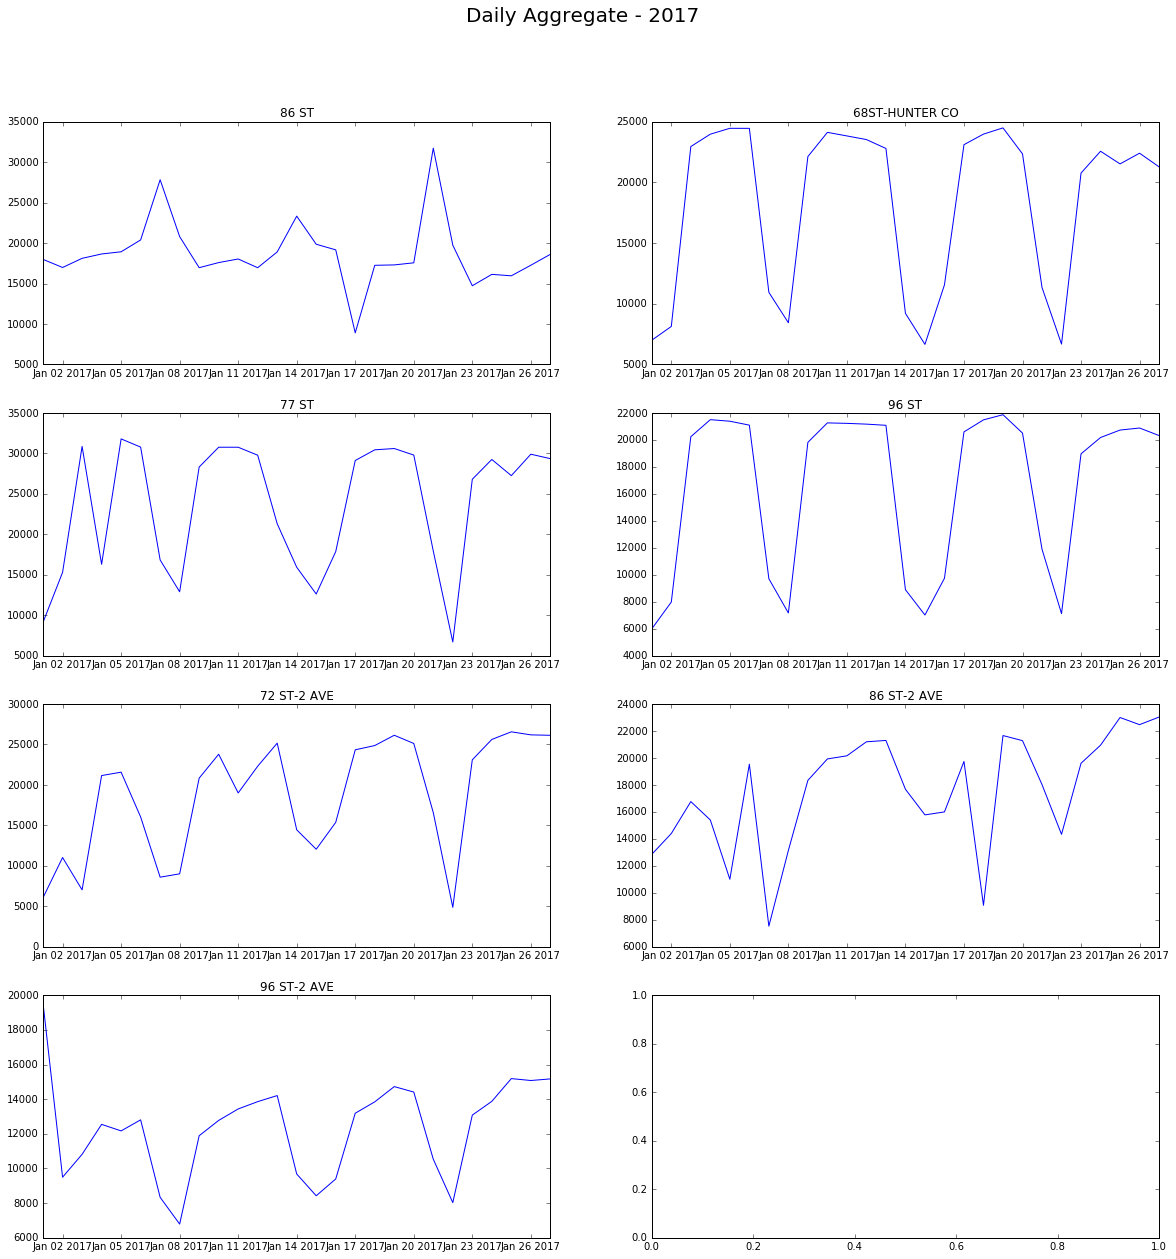

In [989]:
fig, axs = pl.subplots(4, 2, figsize = (20,20))
axs = axs.ravel()
for i, station in enumerate(UES_jan2017.STATION.unique()): 
    temp = UES_jan2017[UES_jan2017.STATION == station].groupby('DATE', as_index = False).sum()
    axs[i].plot(temp.DATE, temp.NEW_ENTRIES, '-')
    axs[i].set_title(station)
pl.suptitle('Daily Aggregate - 2017', fontsize = 20)


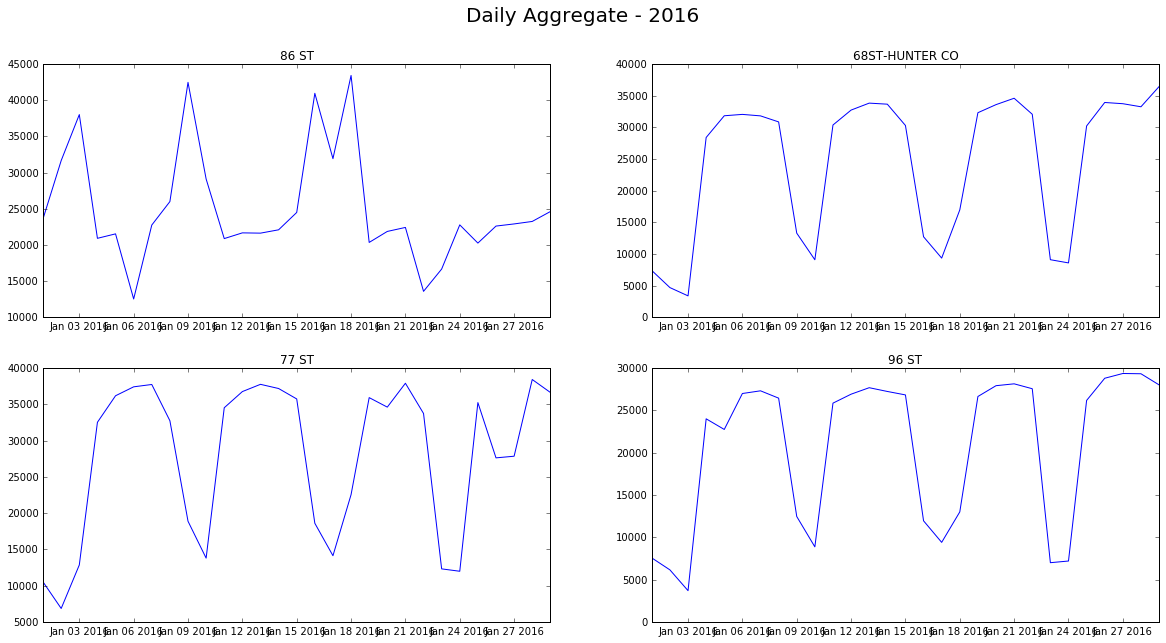

In [992]:
fig, axs = pl.subplots(2, 2, figsize = (20,10))
axs = axs.ravel()
for i, station in enumerate(UES_jan2016.STATION.unique()): 
    temp = UES_jan2016[UES_jan2016.STATION == station].groupby('DATE', as_index = False).sum()
    axs[i].plot(temp.DATE, temp.NEW_ENTRIES, '-')
    axs[i].set_title(station)
pl.suptitle('Daily Aggregate - 2016', fontsize = 20)

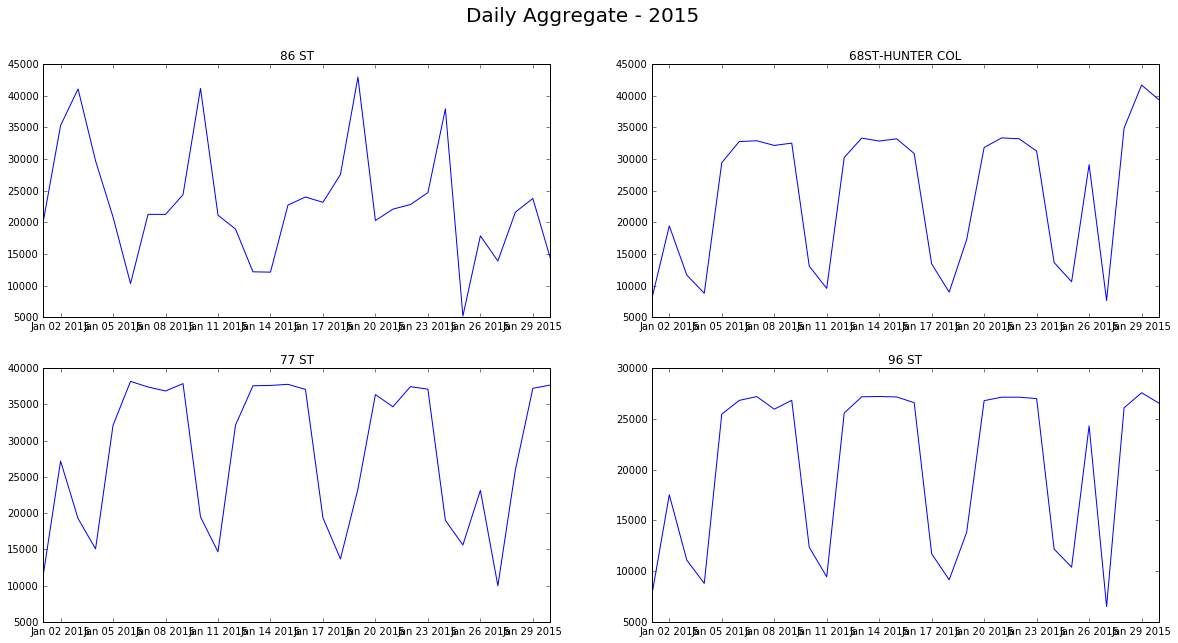

In [993]:
fig, axs = pl.subplots(2, 2, figsize = (20,10))
axs = axs.ravel()
for i, station in enumerate(UES_jan2015.STATION.unique()): 
    temp = UES_jan2015[UES_jan2015.STATION == station].groupby('DATE', as_index = False).sum()
    axs[i].plot(temp.DATE, temp.NEW_ENTRIES, '-')
    axs[i].set_title(station)
pl.suptitle('Daily Aggregate - 2015', fontsize = 20)